# Working with MAT files

Load and display information from MAT files. Plot velocities, correlation strength, and echo intensity to check data quality. Find threshold depths for good data quality, based on binned values of correlation and intensity.

In [2]:
# import modules
import xarray as xr
import datetime
import cmath
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import numpy.ma as ma
import scipy.signal as sig
import scipy.integrate as integ
import scipy.interpolate as interp
import pandas as pd
import seawater as sea
from scipy.stats import chi2
from scipy.io import loadmat
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

for i in range(2):
    %matplotlib notebook

In [6]:
# load .mat file and display info

ds = loadmat('../../../Data/Raw/Axis75_Mar2_2013/Axis75_Mar2_2013_mat.mat')
da = ds['adcp']                                   # adcp data
du = da['u'][0,0]                                 # velocity data
dt = da['time'][0,0][0]                           # time data
dd = np.mean(da['depth'][0,0])-da['range'][0,0]   # depths
print('Shape:',np.shape(da['corr'][0,0]))         # display shape of data
print('Field names:',da.dtype.descr)              # display field names
#print('------------')
#print(ds['units']['time'])                       # display units of selected variable
#print(da.dtype.names)                            # display field names

Shape: (4, 80, 43199)
Field names: [('range', '|O'), ('corr', '|O'), ('intens', '|O'), ('velocity', '|O'), ('percentGood', '|O'), ('ens', '|O'), ('compassHeading', '|O'), ('pitch', '|O'), ('roll', '|O'), ('time', '|O'), ('temperature', '|O'), ('salinity', '|O'), ('pressure', '|O'), ('depth', '|O'), ('soundSpeed', '|O'), ('processingComments', '|O'), ('velocity_sourceInfo', '|O'), ('uvw_sourceInfo', '|O'), ('magneticDeclination', '|O'), ('processingOptions', '|O'), ('u', '|O'), ('v', '|O'), ('w', '|O'), ('velocityError', '|O'), ('backscatter', '|O'), ('meanBackscatter', '|O'), ('backscatterVerticalRange', '|O')]


<IPython.core.display.Javascript object>


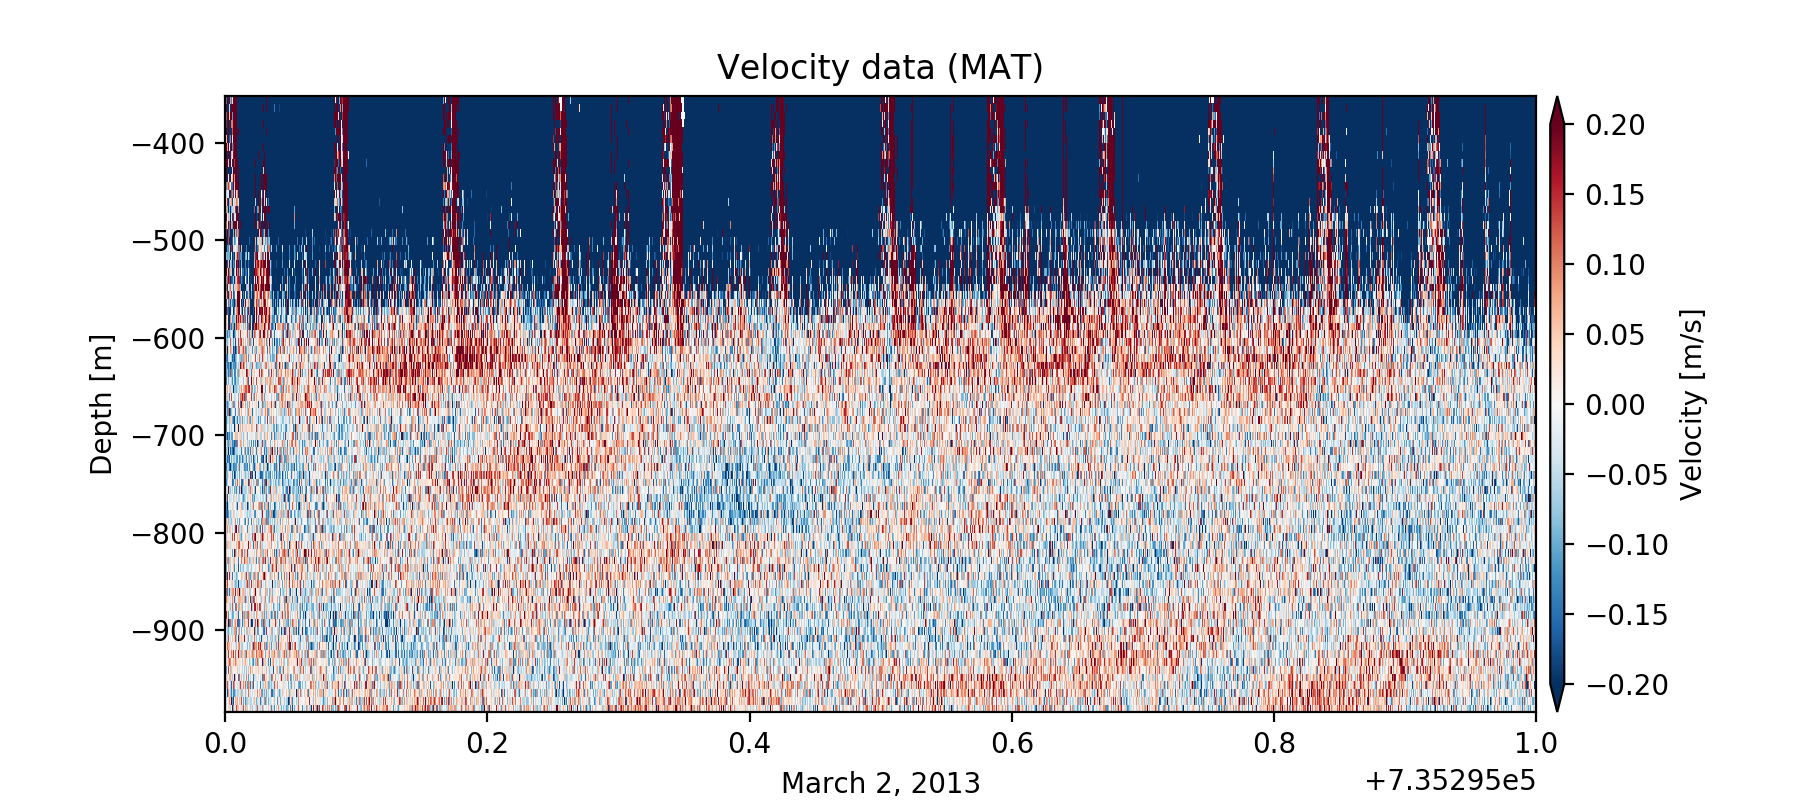

In [8]:
# plot velocity data

fig,ax = plt.subplots(figsize=(9,4))
im = ax.pcolormesh(dt, -dd[0], du, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar.set_label('Velocity [m/s]')
ax.set_xlabel('March 2, 2013')
ax.set_ylabel('Depth [m]')
ax.set_title('Velocity data (MAT)')
plt.show()

<IPython.core.display.Javascript object>


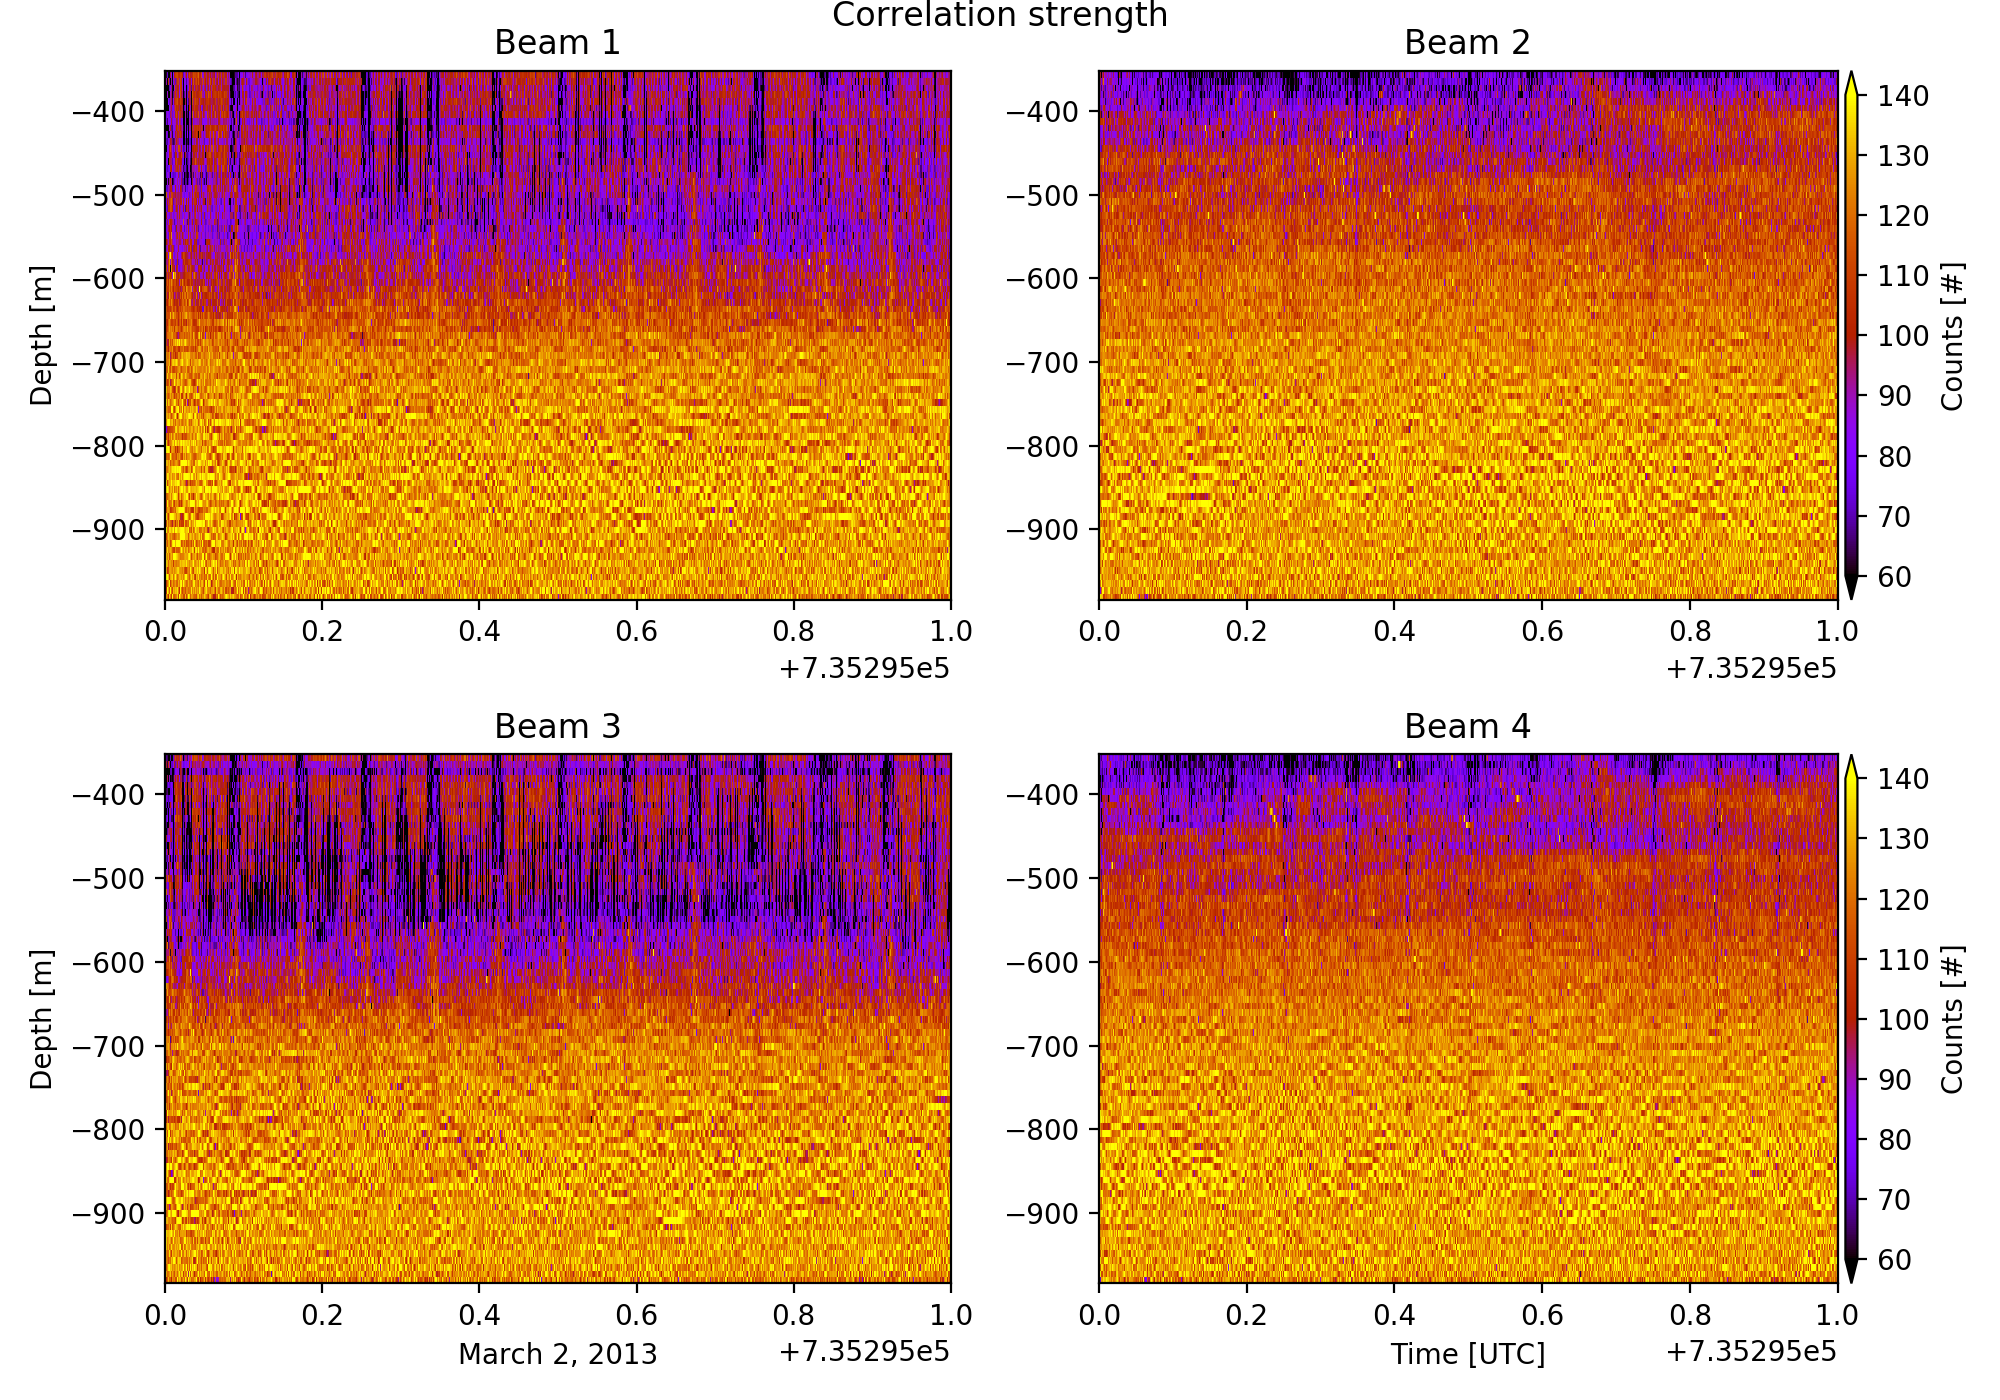

In [9]:
# plot correlation strength

fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(10,7))
plt.subplots_adjust(hspace=0,wspace=0)
vmin=60
vmax=140
cmap='gnuplot'
im0 = ax0.pcolormesh(dt, -dd[0], da['corr'][0,0][0,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
im1 = ax1.pcolormesh(dt, -dd[0], da['corr'][0,0][1,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
im2 = ax2.pcolormesh(dt, -dd[0], da['corr'][0,0][2,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
im3 = ax3.pcolormesh(dt, -dd[0], da['corr'][0,0][3,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar1.set_label('Counts [#]')
cbar3.set_label('Counts [#]')
ax2.set_xlabel('March 2, 2013')
ax3.set_xlabel('Time [UTC]')
ax0.set_ylabel('Depth [m]')
ax2.set_ylabel('Depth [m]')
fig.suptitle('Correlation strength',y=1)
ax0.set_title('Beam 1')
ax1.set_title('Beam 2')
ax2.set_title('Beam 3')
ax3.set_title('Beam 4')
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


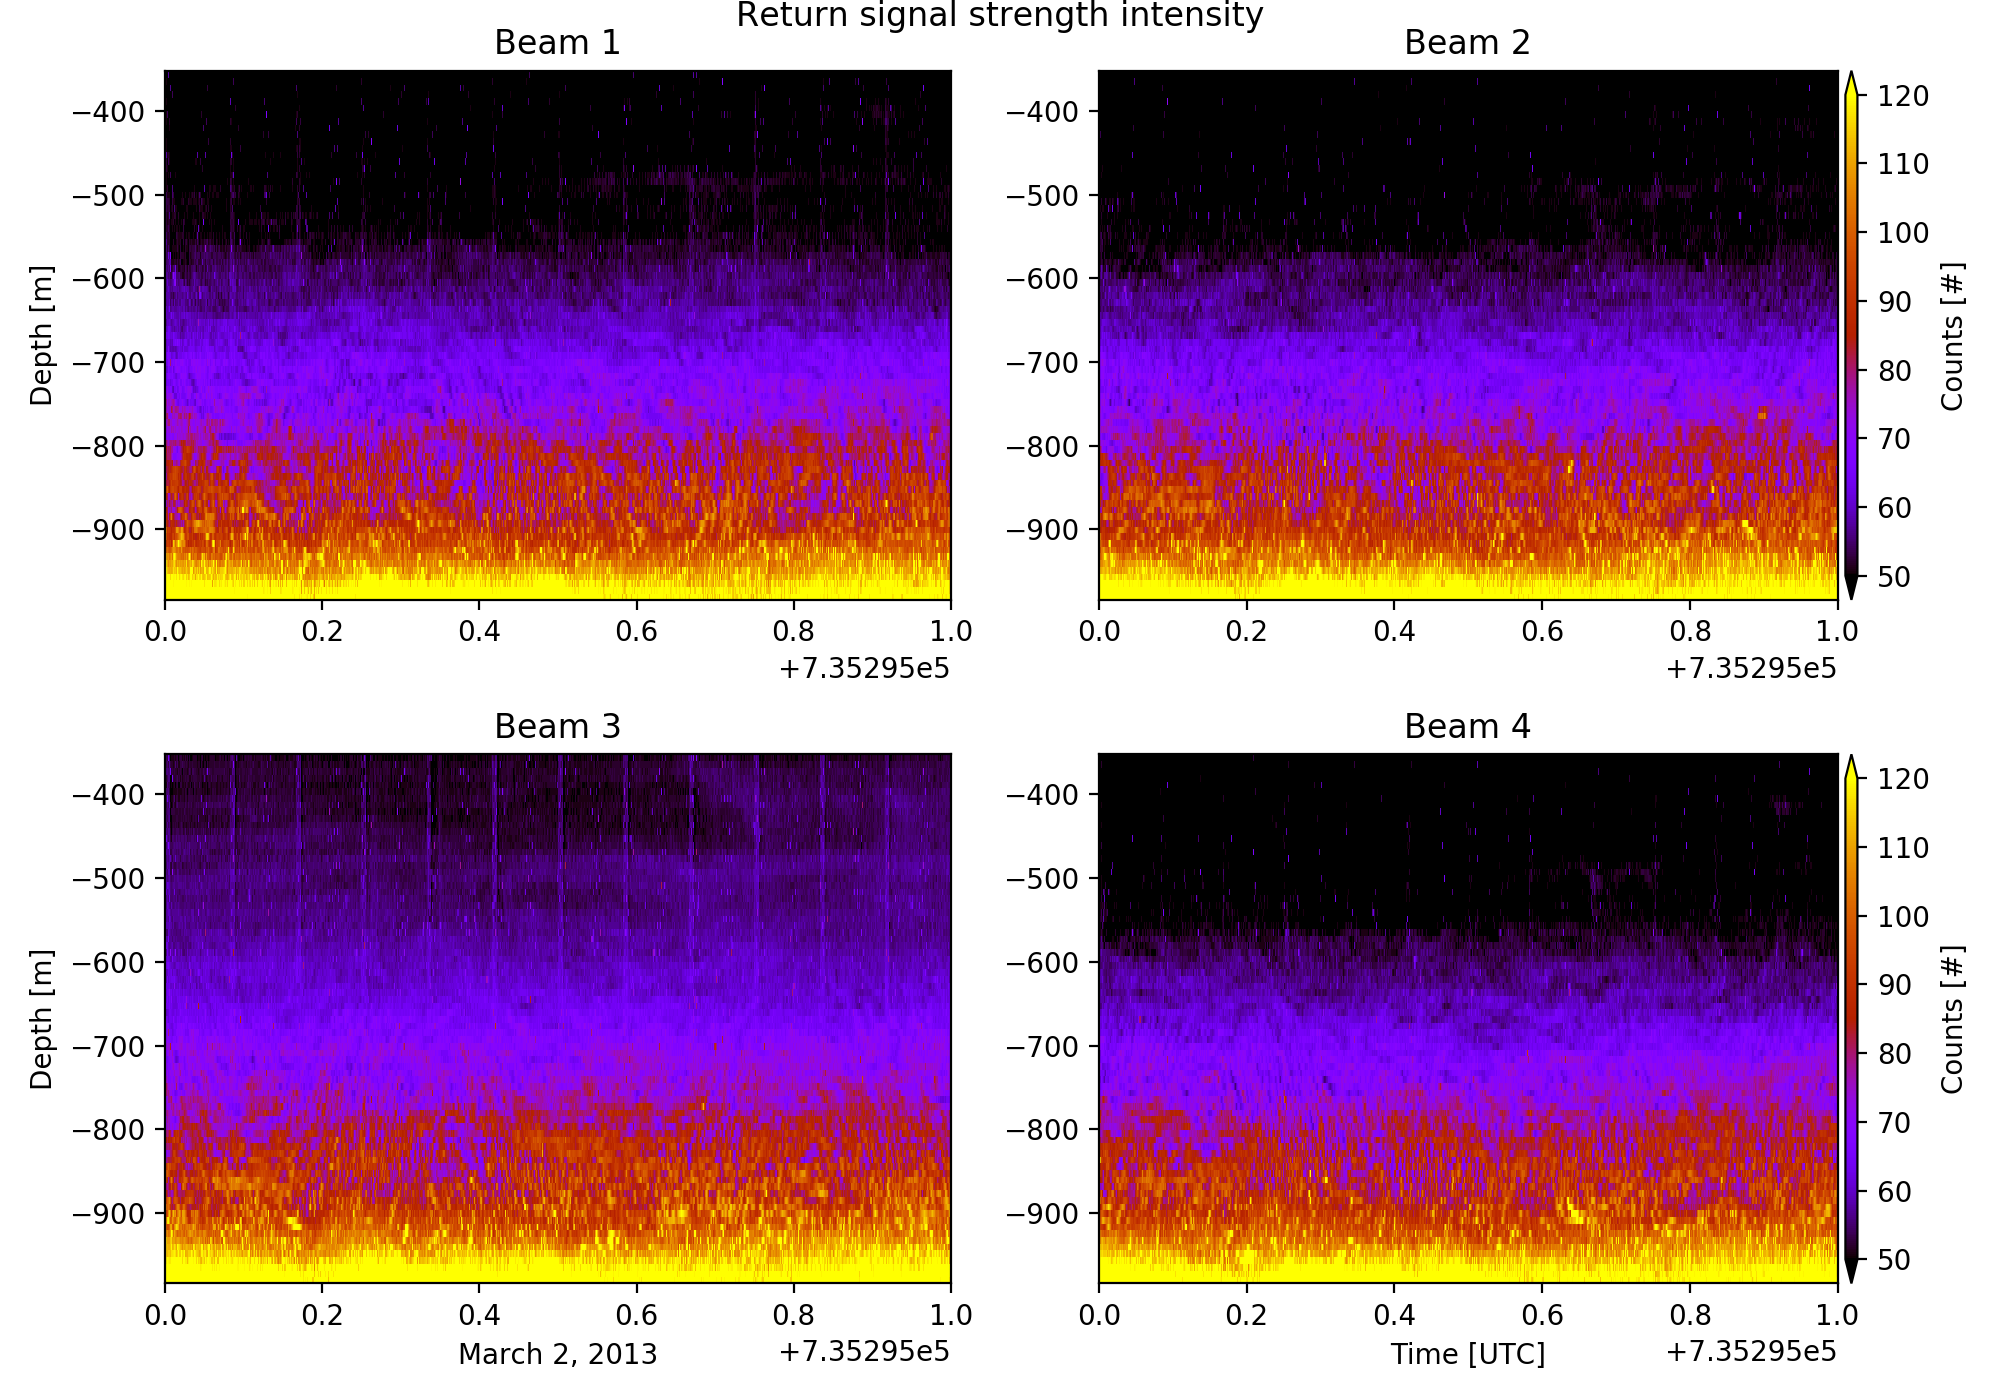

In [10]:
# plot echo intensity

fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(10,7))
plt.subplots_adjust(hspace=0,wspace=0)
vmin=50
vmax=120
cmap='gnuplot'
im0 = ax0.pcolormesh(dt, -dd[0], da['intens'][0,0][0,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
im1 = ax1.pcolormesh(dt, -dd[0], da['intens'][0,0][1,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
im2 = ax2.pcolormesh(dt, -dd[0], da['intens'][0,0][2,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
im3 = ax3.pcolormesh(dt, -dd[0], da['intens'][0,0][3,:,:], rasterized=True, cmap=cmap,vmin=vmin,vmax=vmax)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar1.set_label('Counts [#]')
cbar3.set_label('Counts [#]')
ax2.set_xlabel('March 2, 2013')
ax3.set_xlabel('Time [UTC]')
ax0.set_ylabel('Depth [m]')
ax2.set_ylabel('Depth [m]')
fig.suptitle('Return signal strength intensity',y=1)
ax0.set_title('Beam 1')
ax1.set_title('Beam 2')
ax2.set_title('Beam 3')
ax3.set_title('Beam 4')
fig.tight_layout()
plt.show()

In [11]:
# process to average correlation and intensity into 20 ping bins

pings = 20                                            # number of pings for bins
time_len = len(dt)                                    # length of time axis
t = np.arange(0,time_len,pings)                       # indices of the time axis, in steps = # of pings
t_len = len(t)                                        # length of time indice array
d_len = len(dd[0])                                    # length of depth array
d = np.arange(0,d_len,1)                              # indices of the depth axis
dc = da['corr'][0,0]                                  # correlation matrix from MAT data
di = da['intens'][0,0]                                # intensity matrix from MAT data

corr0_avg = np.empty([d_len,t_len])                   # empty array for binned correlation values
corr1_avg = np.empty([d_len,t_len])                   
corr2_avg = np.empty([d_len,t_len])                 
corr3_avg = np.empty([d_len,t_len])                   
intens0_avg = np.empty([d_len,t_len])                 # empty array for binned intensity values
intens1_avg = np.empty([d_len,t_len])                
intens2_avg = np.empty([d_len,t_len])                 
intens3_avg = np.empty([d_len,t_len])                

count = 0                                             # keeps track of binned time index
for i in t:                                           # loop to group time axis into bins
    if i <= t[-1]:                                    # avoids the final time index
        t_range = dt[i:i+(pings-1)]                   # time index range for # of pings
        corr0_temp = np.empty(d_len)                  # temporary array for averaging
        corr1_temp = np.empty(d_len)                  
        corr2_temp = np.empty(d_len)                  
        corr3_temp = np.empty(d_len)                  
        intens0_temp = np.empty(d_len)                
        intens1_temp = np.empty(d_len)                
        intens2_temp = np.empty(d_len)                
        intens3_temp = np.empty(d_len)                
        for j in d:                                             # need to average at each depth
            corr0_temp[j] = np.nanmean(dc[0,j,i:i+(pings-1)])   # average values over bin times at each depth
            corr1_temp[j] = np.nanmean(dc[1,j,i:i+(pings-1)])  
            corr2_temp[j] = np.nanmean(dc[2,j,i:i+(pings-1)])  
            corr3_temp[j] = np.nanmean(dc[3,j,i:i+(pings-1)])  
            intens0_temp[j] = np.nanmean(di[0,j,i:i+(pings-1)])  
            intens1_temp[j] = np.nanmean(di[1,j,i:i+(pings-1)])  
            intens2_temp[j] = np.nanmean(di[2,j,i:i+(pings-1)])  
            intens3_temp[j] = np.nanmean(di[3,j,i:i+(pings-1)])  
        corr0_avg[:,count] = corr0_temp                         # set averaged depths to binned time index
        corr1_avg[:,count] = corr1_temp               
        corr2_avg[:,count] = corr2_temp               
        corr3_avg[:,count] = corr3_temp               
        intens0_avg[:,count] = intens0_temp               
        intens1_avg[:,count] = intens1_temp               
        intens2_avg[:,count] = intens2_temp               
        intens3_avg[:,count] = intens3_temp          
    count += 1                                                  # move to next binned time index

In [14]:
# process to determine threshold depths

corr_thres = 100                                                # set correlation threshold
intens_thres = 60                                               # set intensity threshold
corr0_eval = np.empty(t_len)                                    # empty arrays for evaluated depths
corr1_eval = np.empty(t_len)
corr2_eval = np.empty(t_len)
corr3_eval = np.empty(t_len)
intens0_eval = np.empty(t_len)
intens1_eval = np.empty(t_len)
intens2_eval = np.empty(t_len)
intens3_eval = np.empty(t_len)

for i in range(t_len):                                          # loops to find threshold depths at each ping bin
    for j in d:                                                 # check each depth
        if corr0_avg[j,i] <= corr_thres:                        # when value falls below threshold
            corr0_eval[i] = dd[0][j]                            # set this depth for this ping bin
            break                                               # break to next beam
        else:                                                   # if doesn't meet threshold, set NaN
            corr0_eval[i] = np.nan
        continue
    for j in d:
        if corr1_avg[j,i] <= corr_thres:
            corr1_eval[i] = dd[0][j]
            break
        else:
            corr1_eval[i] = np.nan
        continue
    for j in d:
        if corr2_avg[j,i] <= corr_thres:
            corr2_eval[i] = dd[0][j]
            break
        else:
            corr2_eval[i] = np.nan
        continue
    for j in d:
        if corr3_avg[j,i] <= corr_thres:
            corr3_eval[i] = dd[0][j]
            break
        else:
            corr3_eval[i] = np.nan
        continue
        
    for j in d:
        if intens0_avg[j,i] <= intens_thres:
            intens0_eval[i] = dd[0][j]
            break
        else:
            intens0_eval[i] = np.nan
        continue
    for j in d:
        if intens1_avg[j,i] <= intens_thres:
            intens1_eval[i] = dd[0][j]
            break
        else:
            intens1_eval[i] = np.nan
        continue
    for j in d:
        if intens2_avg[j,i] <= intens_thres:
            intens2_eval[i] = dd[0][j]
            break
        else:
            intens2_eval[i] = np.nan
        continue
    for j in d:
        if intens3_avg[j,i] <= intens_thres:
            intens3_eval[i] = dd[0][j]
            break
        else:
            intens3_eval[i] = np.nan
        continue
        
corr0_depth = int(np.nanmean(corr0_eval))                                 # find beam threshold depth
corr1_depth = int(np.nanmean(corr1_eval))
corr2_depth = int(np.nanmean(corr2_eval))
corr3_depth = int(np.nanmean(corr3_eval))
corr_all = np.nanmean([corr0_depth,corr1_depth,corr2_depth,corr3_depth])  # find average threshold depth
intens0_depth = int(np.nanmean(intens0_eval))
intens1_depth = int(np.nanmean(intens1_eval))
intens2_depth = int(np.nanmean(intens2_eval))
intens3_depth = int(np.nanmean(intens3_eval))
intens_all = np.nanmean([intens0_depth,intens1_depth,intens2_depth,intens3_depth])

print('For this time range, beam 0 correlation falls below',corr_thres,'counts at an average depth of',-corr0_depth,'m.')
print('For this time range, beam 1 correlation falls below',corr_thres,'counts at an average depth of',-corr1_depth,'m.')
print('For this time range, beam 2 correlation falls below',corr_thres,'counts at an average depth of',-corr2_depth,'m.')
print('For this time range, beam 3 correlation falls below',corr_thres,'counts at an average depth of',-corr3_depth,'m.')
print('Average correlation threshold depth:',-corr_all,'m.')
print('--------------------')
print('For this time range, beam 0 intensity falls below',intens_thres,'counts at an average depth of',-intens0_depth,'m.')
print('For this time range, beam 1 intensity falls below',intens_thres,'counts at an average depth of',-intens1_depth,'m.')
print('For this time range, beam 2 intensity falls below',intens_thres,'counts at an average depth of',-intens2_depth,'m.')
print('For this time range, beam 3 intensity falls below',intens_thres,'counts at an average depth of',-intens3_depth,'m.')
print('Average intensity threshold depth:',-intens_all,'m.')

For this time range, beam 0 correlation falls below 100 counts at an average depth of -635 m.
For this time range, beam 1 correlation falls below 100 counts at an average depth of -532 m.
For this time range, beam 2 correlation falls below 100 counts at an average depth of -669 m.
For this time range, beam 3 correlation falls below 100 counts at an average depth of -534 m.
Average correlation threshold depth: -592.5 m.
--------------------
For this time range, beam 0 intensity falls below 60 counts at an average depth of -673 m.
For this time range, beam 1 intensity falls below 60 counts at an average depth of -673 m.
For this time range, beam 2 intensity falls below 60 counts at an average depth of -619 m.
For this time range, beam 3 intensity falls below 60 counts at an average depth of -668 m.
Average intensity threshold depth: -658.25 m.
